In [2]:
import sys
!{sys.executable} -m pip install pomegranate ipympl > /dev/null

In [3]:
from pomegranate import *
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Discrete distribution for indels
i_d = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})

# Insertion states
i0 = State(i_d, name="I0")
i1 = State(i_d, name="I1")
i2 = State(i_d, name="I2")
i3 = State(i_d, name="I3")

# Match states
m1 = State(DiscreteDistribution({'A': 0.95, 'C': 0.01, 'G': 0.01, 'T': 0.02}), name="M1")
m2 = State(DiscreteDistribution({'A': 0.003, 'C': 0.99, 'G': 0.003, 'T': 0.004}), name="M2")
m3 = State(DiscreteDistribution({'A': 0.01, 'C': 0.01, 'G': 0.01, 'T': 0.97}), name="M3")

# Delete states
d1 = State(None, name="D1")
d2 = State(None, name="D2")
d3 = State(None, name="D3")

In [5]:
model = HiddenMarkovModel()

# Add states to the model
model.add_states([i0, i1, i2, i3, m1, m2, m3, d1, d2, d3])

# Create transitions from model start
model.add_transition( model.start, m1, 0.9 )
model.add_transition( model.start, i0, 0.1 )

# Create transitions from match states
model.add_transition( m1, m2, 0.9 )
model.add_transition( m1, i1, 0.05 )
model.add_transition( m1, d2, 0.05 )

model.add_transition( m2, m3, 0.9 )
model.add_transition( m2, i2, 0.05 )
model.add_transition( m2, d3, 0.05 )

model.add_transition( m3, model.end, 0.9 )
model.add_transition( m3, i3, 0.1 )

# Create transitions from insert states
model.add_transition( i0, i0, 0.70 )
model.add_transition( i0, d1, 0.15 )
model.add_transition( i0, m1, 0.15 )

model.add_transition( i1, i1, 0.70 )
model.add_transition( i1, d2, 0.15 )
model.add_transition( i1, m2, 0.15 )

model.add_transition( i2, i2, 0.70 )
model.add_transition( i2, d3, 0.15 )
model.add_transition( i2, m3, 0.15 )

model.add_transition( i3, i3, 0.85 )
model.add_transition( i3, model.end, 0.15 )

# Create transitions from delete states
model.add_transition( d1, d2, 0.15 )
model.add_transition( d1, i1, 0.15 )
model.add_transition( d1, m2, 0.70 ) 

model.add_transition( d2, d3, 0.15 )
model.add_transition( d2, i2, 0.15 )
model.add_transition( d2, m3, 0.70 )

model.add_transition( d3, i3, 0.30 )
model.add_transition( d3, model.end, 0.70 )

# Finalize model structure
model.bake()

In [6]:
for sequence in map( list, ('ACT', 'GGC', 'GAT', 'ACC') ):
    logp, path = model.viterbi( sequence )
    print(f"Sequence: '{''.join(sequence)}'  -- Log Probability: {logp} -- Path: {''.join(state.name for idx, state in path[1:-1])}")

Sequence: 'ACT'  -- Log Probability: -0.5132449003570658 -- Path: M1M2M3
Sequence: 'GGC'  -- Log Probability: -11.048101241343396 -- Path: I0I0D1M2D3
Sequence: 'GAT'  -- Log Probability: -9.125519674022627 -- Path: I0M1D2M3
Sequence: 'ACC'  -- Log Probability: -5.0879558788604475 -- Path: M1M2M3


In [7]:
for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC', 'ACGTG', 'ATTT', 'TACCCTC', 'TGTCAACACT') ):
    logp, path = model.viterbi( sequence )
    print(f"Sequence: '{''.join(sequence)}'  -- Log Probability: {logp} -- Path: {''.join(state.name for idx, state in path[1:-1])}")

Sequence: 'A'  -- Log Probability: -5.406181012423981 -- Path: M1D2D3
Sequence: 'GA'  -- Log Probability: -10.88681993576597 -- Path: I0M1D2D3
Sequence: 'AC'  -- Log Probability: -3.6244718790494277 -- Path: M1M2D3
Sequence: 'AT'  -- Log Probability: -3.644880750680635 -- Path: M1D2M3
Sequence: 'ATCC'  -- Log Probability: -10.674332964640293 -- Path: M1D2M3I3I3
Sequence: 'ACGTG'  -- Log Probability: -10.393824835172445 -- Path: M1M2I2I2I2D3
Sequence: 'ATTT'  -- Log Probability: -8.67126440174503 -- Path: M1I1I1D2M3
Sequence: 'TACCCTC'  -- Log Probability: -16.903451796110275 -- Path: I0I0I0I0D1M2M3I3
Sequence: 'TGTCAACACT'  -- Log Probability: -16.451699654050792 -- Path: I0I0I0I0I0I0I0M1M2M3


In [8]:
def path_to_alignment( x, y, path ):
    """
    This function will take in two sequences, and the ML path which is their alignment,
    and insert dashes appropriately to make them appear aligned. This consists only of
    adding a dash to the model sequence for every insert in the path appropriately, and
    a dash in the observed sequence for every delete in the path appropriately.
    """
    
    for i, (index, state) in enumerate( path[1:-1] ):
        name = state.name
        
        if name.startswith( 'D' ):
            y = y[:i] + '-' + y[i:]
        elif name.startswith( 'I' ):
            x = x[:i] + '-' + x[i:]

    return x, y

for sequence in map( list, ('A', 'GA', 'AC', 'AT', 'ATCC' ) ):
    logp, path = model.viterbi( sequence )
    x, y = path_to_alignment( 'ACT', ''.join(sequence), path )
    
    print(f"Sequence: {''.join(sequence)}, Log Probability: {logp}")
    print(f"{x}\n{y}")
    print

Sequence: A, Log Probability: -5.406181012423981
ACT
A--
Sequence: GA, Log Probability: -10.88681993576597
-ACT
GA--
Sequence: AC, Log Probability: -3.6244718790494277
ACT
AC-
Sequence: AT, Log Probability: -3.644880750680635
ACT
A-T
Sequence: ATCC, Log Probability: -10.674332964640293
ACT--
A-TCC


In [9]:
import itertools as it
from functools import reduce

sequences = reduce( lambda x, y: x+y, [[ seq for seq in it.product( 'ACGT', repeat=i ) ] for i in range( 1,6 )] )
scores = list(map( model.log_probability, sequences ))

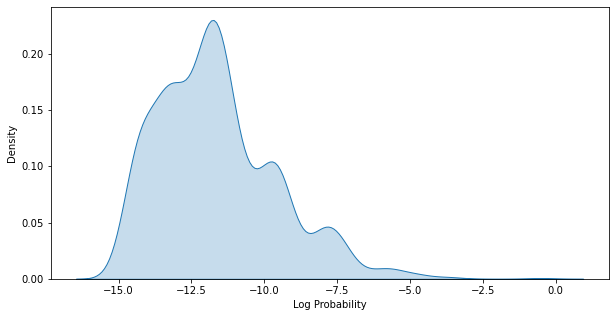

In [10]:
plt.figure( figsize=(10,5) )
plt.ylabel('Density')
plt.xlabel('Log Probability')
sns.kdeplot( numpy.array( scores ), shade=True )
plt.show()

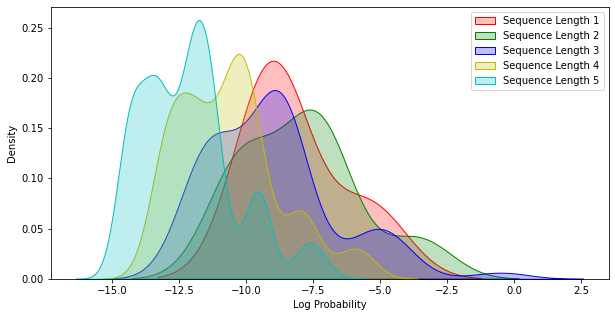

In [11]:
plt.figure( figsize=(10,5) )
for i in range( 1, 6 ):
    subset = it.product( 'ACGT', repeat=i )
    subset_scores = list(map( model.log_probability, subset ))
    sns.kdeplot( numpy.array( subset_scores ), color='rgbyc'[i-1], shade=True, label="Sequence Length " + str(i) )
plt.ylabel('Density')
plt.xlabel('Log Probability')
plt.legend()

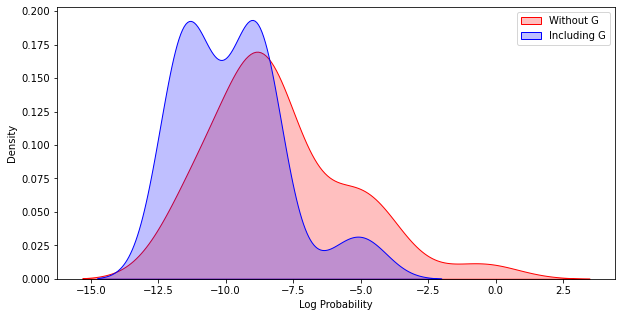

In [12]:
plt.figure( figsize=(10, 5) )

subsequences = it.product( 'ACT', repeat=3 )
scores = list(map( model.log_probability, subsequences ))

sns.kdeplot( numpy.array( scores ), color='r', shade=True, label='Without G' )

subsequences = filter( lambda seq: 'G' in seq, it.product( 'ACGT', repeat=3 ) )
scores = list(map( model.log_probability, subsequences ))

sns.kdeplot( numpy.array( scores ), color='b', shade=True, label='Including G')

plt.ylabel('Density')
plt.xlabel('Log Probability')
plt.legend()

In [13]:
d1 = DiscreteDistribution({'A': 0.25, 'C': 0.25, 'G': 0.25, 'T': 0.25})
d2 = DiscreteDistribution({'A': 0.10, 'C': 0.40, 'G': 0.40, 'T': 0.10})

In [14]:
s1 = State(d1, name='background')
s2 = State(d2, name='CpG island')

In [15]:
model = HiddenMarkovModel()
model.add_states(s1, s2)

model.add_transition(model.start, s1, 0.50)
model.add_transition(model.start, s2, 0.50)

model.add_transition(s1, s1, 0.89)
model.add_transition(s1, s2, 0.10)
model.add_transition(s1, model.end, 0.01)

model.add_transition(s2, s1, 0.10)
model.add_transition(s2, s2, 0.90)

model.bake()

In [16]:
seq = numpy.array(list('CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'))
hmm_predictions = model.predict(seq)

print(f"sequence: {''.join(seq)}")
print(f"hmm pred: {''.join(map(str, hmm_predictions))}")

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 111111111111111000000000000000011111111111111111111


In [17]:
print(model.predict_proba(seq)[12:19])

[[0.19841088 0.80158912]
 [0.32919701 0.67080299]
 [0.38366073 0.61633927]
 [0.58044619 0.41955381]
 [0.69075524 0.30924476]
 [0.74653183 0.25346817]
 [0.76392808 0.23607192]]


In [18]:
trans, ems = model.forward_backward(seq)
print(trans)

[[15.78100555  2.89559314  0.          0.        ]
 [ 2.41288774 28.91051356  0.          1.        ]
 [ 0.4827054   0.5172946   0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [19]:
sr = State(DiscreteDistribution({'walk': 0.1, 'shop': 0.4, 'clean': 0.5}), name="Rainy")
ss = State(DiscreteDistribution({'walk': 0.6, 'shop': 0.3, 'clean': 0.1}), name="Sunny")

model = HiddenMarkovModel()
model.add_states(sr, ss)

model.add_transition(model.start, sr, 0.6)
model.add_transition(model.start, ss, 0.4)

model.add_transition(sr, sr, 0.7)
model.add_transition(sr, ss, 0.3)

model.add_transition(ss, ss, 0.6)
model.add_transition(ss, sr, 0.4)

model.bake()

In [20]:
hmm_pred = model.predict(['walk', 'shop', 'walk', 'clean', 'clean', 'shop', 'clean'])

print(f"{''.join(map(str, hmm_pred))}")

1110000
